In [88]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

ds = xr.open_dataset(f"/data/pca_act/000_clean.nc")
ti_nan = (np.count_nonzero(np.isnan(ds.nbart_blue.values), axis=(1,2)))<.66*160000
ds = ds.isel(time=ti_nan)

In [135]:
mask = np.zeros(ds.nbart_red.shape).astype(np.bool)

def generate_patches(stack, patch_hsize):
    i = int(np.random.randint(patch_hsize, 400-patch_hsize, size=1))
    j = int(np.random.randint(patch_hsize, 400-patch_hsize, size=1))
    t = int(np.random.randint(stack.shape[0], size=1))
    
    while np.count_nonzero(~np.isnan(stack[t, j-patch_hsize:j+patch_hsize, i-patch_hsize:i+patch_hsize])) != (2*patch_hsize)**2:
        t = int(np.random.randint(stack.shape[0], size=1))
        i = int(np.random.randint(patch_hsize, 400-patch_hsize, size=1))
        j = int(np.random.randint(patch_hsize, 400-patch_hsize, size=1))
                    
    return t, i, j

patch_hsize = 40

for _ in range(30):
    t, i, j = generate_patches(ds.nbart_red.values, patch_hsize)
    
    mask[t, j-patch_hsize:j+patch_hsize, i-patch_hsize:i+patch_hsize] = True

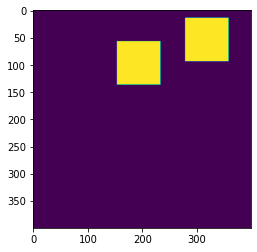

In [136]:
plt.imshow(mask[2])

In [137]:
stack = np.empty((0,400,400))
stack_int = np.empty((0,400,400))
stack_mask = np.empty((0,400,400))

for fname in ds:
    print(fname)
    stack = np.append(stack, ds[fname].values/1e4, axis=0)
    band = ds[fname].where(~mask)
    stack_mask = np.append(stack_mask, band.values/1e4, axis=0)
    band = band.interpolate_na(dim='time')
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')
    stack_int = np.append(stack_int, band.values/1e4, axis=0)

print(stack.shape, stackint.shape)

nbart_red
nbart_green
nbart_blue
nbart_nir_1
nbart_nir_2
nbart_swir_2
nbart_swir_3
(497, 400, 400) (497, 400, 400)


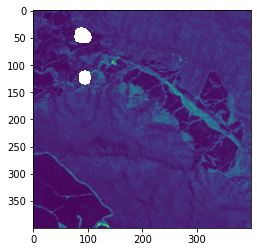

In [138]:
plt.imshow(stack[2])

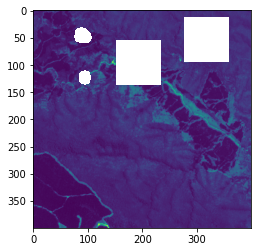

In [139]:
plt.imshow(stack_mask[2])

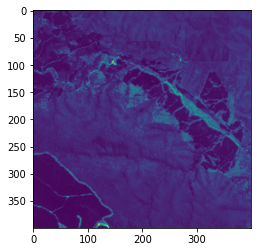

In [140]:
plt.imshow(stack_int[2])

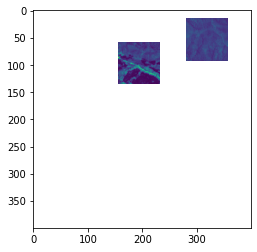

In [141]:
true_rec = np.where(np.repeat(mask[None,:],7,axis=0), stack.reshape(7,-1,400,400), np.nan).reshape(-1,400,400)

plt.imshow(true_rec[2])

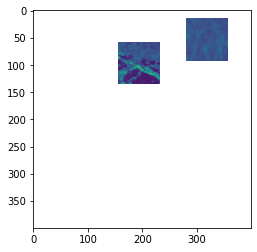

In [142]:
pca = PCA(n_components=12).fit(stackint.reshape(-1,160000))
coeffs = pca.transform(stackint.reshape(-1,160000))
pca_decomp = pca.inverse_transform(coeffs)
    
pca_rec = pca_decomp.reshape(7,-1,400,400)
pca_rec = np.where(np.repeat(mask[None,:],7,axis=0),pca_rec, np.nan)
pca_rec = pca_rec.reshape(-1,400,400)

plt.imshow(pca_rec[2])

In [143]:
np.nanmean(np.square(pca_decomp.reshape(-1,400,400) - stack_mask))

5.240752624599982e-05

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


class MF(nn.Module):
    def __init__(self, n_coeffs, n_comps, n_pix):
        super(MF, self).__init__()
        self.cfs = nn.Parameter(torch.rand(n_coeffs, n_comps, requires_grad=True))
        self.cmps = nn.Parameter(torch.rand(n_comps, n_pix, requires_grad=True))

    def forward(self):
        return torch.matmul(self.cfs,self.cmps)

    
def nan_mse_loss(output, target):
    loss = torch.mean((output[target == target] - target[target == target])**2)
    return loss


stack_mean = np.nanmean(stack_mask.reshape(-1,160000), axis=0)
target = torch.from_numpy(stack_mask.reshape(-1,160000)-stack_mean).float().to(device)

ncomps = 12
ncoeffs = stack.shape[0]
npix = 160000

net = MF(ncoeffs, ncomps, npix)
net.to(device)


opt = optim.AdamW(net.parameters(), lr=1.0)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = nan_mse_loss(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, loss.item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20


opt = optim.AdamW(net.parameters(), lr=0.001)

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = nan_mse_loss(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    if epoch == 0:
        print(loss.item())

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(epoch, loss.item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20

cuda:0
0 9.412201881408691
100 0.0003951874386984855


In [ ]:
np.nanmean(np.square((net().cpu().detach().numpy()+stack_mean).reshape(-1,400,400) - stack_mask))

In [ ]:
nn_rec = (net().cpu().detach().numpy()+stack_mean).reshape(7,-1,400,400)
nn_rec = np.where(np.repeat(mask[None,:],7,axis=0),nn_rec, np.nan)
nn_rec = nn_rec.reshape(-1,400,400)

plt.imshow(nn_rec[2])

In [ ]:
np.nanmean(true_rec-pca_rec.reshape(-1,400,400))

In [ ]:
np.nanmean(true_rec-nn_rec.reshape(-1,400,400))

In [ ]:
nn_rec = (net().cpu().detach().numpy()+stack_mean).reshape(7,-1,400,400)
#nn_rec = np.where(np.repeat(mask[None,:],7,axis=0),nn_rec, np.nan)

plt.imshow(nn_rec[0,2])